In [1]:
import os
import tensorflow as tf
import numpy as np
import os
import time
import scipy.io
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
STYLE_IMAGE = './style/guernica.jpg'
CONTENT_IMAGE = './content/deadpool.jpg'
IMAGE_WIDTH = 600
IMAGE_HEIGHT = 500
IMAGE_CHANNELS = 3
NOISE_RATIO = 0.6 #amount of noise for intermixing with the content image
STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
W = [0.5, 1.0, 1.5, 3.0, 4.0] # give more weights to deeper layers.
CONTENT_LAYER = 'conv4_2'
ITERS = 300
LR = 2.0
ALPHA = 5
BETA = 100
#the mean pixels are subtracted from the input image for normalization purposes ie. to center the data
MEAN_PIXELS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
VGG_MODEL = './vgg19/imagenet-vgg-verydeep-19.mat'

FILENAME = './outputs/' + STYLE_IMAGE.split('/')[-1].split('.')[0] + \
'_' + CONTENT_IMAGE.split('/')[-1].split('.')[0] + '.jpg'

In [3]:
def load_weights(vgg_layers, layer, expected_layer_name):
    #vgg_layers.shape : (1,43) 
    #vgg_layers[0][x] : details of xth layer
    #vgg_layers[0][x].shape : (1,1) ie. matrix of one element
    #vgg_layers[0][x][0][0] : to access that one element (it's of the dtype=object)
    #The object is composed of an array of name,type,weights,size,pad,stride,precious,dilate,opts
    #vgg_layers[0][x][0][0][0]: name of layer (layer name enclosed in quotes preceeded by u, eg: u'conv1_1')
    #vgg_layers[0][x][0][0][1]: type of layer ie. conv/relu etc (actually the layer name, eg: conv1_1)
    #vgg_layers[0][x][0][0][2]: all weights including biases (shape: (1,2))
    #vgg_layers[0][x][0][0][2][0][0]: weights
    #vgg_layers[0][x][0][0][2][0][1]: biases
    w = vgg_layers[0][layer][0][0][2][0][0]
    b = vgg_layers[0][layer][0][0][2][0][1]
    layer_name = vgg_layers[0][layer][0][0][0][0]
    assert layer_name == expected_layer_name
    #resize b to shape (F,) as it is of shape (F,1) where F: no. of filters in that layer
    return w,b.reshape(b.size)

In [4]:
def conv2d_relu(vgg_layers, prev_layer, layer, layer_name):
    #prev_layer: o/p of previous layer ie. i/p to current layer
    with tf.variable_scope(layer_name) as scope:
        w,b = load_weights(vgg_layers, layer, layer_name)
        w = tf.constant(w,name='weights')
        b = tf.constant(b,name='bias')
        conv2d = tf.nn.conv2d(input=prev_layer, filter=w, strides=[1,1,1,1], padding='SAME') + b
    return tf.nn.relu(conv2d)

In [5]:
def avg_pool(prev_layer):
    return tf.nn.avg_pool(prev_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='avg_pool')

In [6]:
def load_vgg(path, input_image):
    #Loading VGG into a TensorFlow model
    vgg = scipy.io.loadmat(path) #returns a dictionary with variable names as keys and loaded matrices as values
    vgg_layers = vgg['layers']

    #using dictionary to hold the model insead of a python class
    graph = {} 
    graph['conv1_1']  = conv2d_relu(vgg_layers, input_image, 0, 'conv1_1') #0: conv1_1, 1: relu1_1
    graph['conv1_2']  = conv2d_relu(vgg_layers, graph['conv1_1'], 2, 'conv1_2') #2: conv1_2, 3: relu1_2
    graph['avgpool1'] = avg_pool(graph['conv1_2']) #4: pool1
    graph['conv2_1']  = conv2d_relu(vgg_layers, graph['avgpool1'], 5, 'conv2_1') #5: conv2_1, 6: relu2_1
    graph['conv2_2']  = conv2d_relu(vgg_layers, graph['conv2_1'], 7, 'conv2_2') #7: conv2_2, 8: relu2_2
    graph['avgpool2'] = avg_pool(graph['conv2_2']) #9: pool2
    graph['conv3_1']  = conv2d_relu(vgg_layers, graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = conv2d_relu(vgg_layers, graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = conv2d_relu(vgg_layers, graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = conv2d_relu(vgg_layers, graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = avg_pool(graph['conv3_4'])
    graph['conv4_1']  = conv2d_relu(vgg_layers, graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = conv2d_relu(vgg_layers, graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = conv2d_relu(vgg_layers, graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = conv2d_relu(vgg_layers, graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = avg_pool(graph['conv4_4'])
    graph['conv5_1']  = conv2d_relu(vgg_layers, graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = conv2d_relu(vgg_layers, graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = conv2d_relu(vgg_layers, graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = conv2d_relu(vgg_layers, graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = avg_pool(graph['conv5_4'])
    
    return graph

In [7]:
def get_content_loss(p,f):
    #p and f are the feature representations of the content(original) image and the generated image respectively
    #at layer l
    #return 0.5 * tf.reduce_sum(tf.square(f-p)) #this is slow to converge so replaced with code below
    return tf.reduce_sum(tf.square(f-p)) / (4 * p.size)

In [8]:
def gram_matrix(f,N,M):
    f = tf.reshape(f,(N,M))
    return tf.matmul(f,tf.transpose(f))

In [9]:
def get_single_style_loss(a,g):
    #a and g are the feature representations of the style(original) image and the generated image respectively
    # at layer l
    
    '''
    N is the third dimension of the feature map.
    M is the product of the first two dimensions of the feature map.
    However, in TensorFlow, we have to add one extra dimension to make it 4D
    to make it work for the function tf.nn.conv2d.
    So the first dimension is actually the second, and the second is the third, and so on.
    '''
    
    N = a.shape[3] #no. of filters 
    M = a.shape[1] * a.shape[2] #height * width
    A = gram_matrix(a,N,M)
    G = gram_matrix(g,N,M)
    
    return tf.reduce_sum(tf.square(G-A)) / (4 * N * N * M * M)

In [10]:
def get_style_loss(a,model):
    #a is an array of feature representations of the original image
    n_style_layers = len(STYLE_LAYERS)
    E = [get_single_style_loss(a[i],model[STYLE_LAYERS[i]]) for i in range(n_style_layers)]
    return tf.reduce_sum([W[i] * E[i] for i in range(n_style_layers)])

In [11]:
def get_loss(model, input_image, content_image, style_image):
    #input_image is a tensorflow variable. content_image and style_image are image matrices
    #work flow: assign content and style images to input_image variable and create nodes in graph for noise image
    # for calculating losses. nothing is evaluated as of yet, just nodes formed
    with tf.variable_scope("loss") as scope:
        with tf.Session() as sess:
            sess.run(input_image.assign(content_image))
            p = sess.run(model[CONTENT_LAYER])
            content_loss = get_content_loss(p,model[CONTENT_LAYER])
            
        with tf.Session() as sess:
            sess.run(input_image.assign(style_image))
            A = [sess.run(model[STYLE_LAYERS[i]]) for i in range(len(STYLE_LAYERS))]
            style_loss = get_style_loss(A,model)
            
    total_loss = ALPHA * content_loss + BETA * style_loss
    return content_loss, style_loss, total_loss

In [12]:
def get_noise_image(content_image, height, width, noise_ratio):
    noise_image = np.random.uniform(-20,20,(1,height,width,3)).astype('float32')
    return noise_ratio * noise_image + (1 - noise_ratio) * content_image

In [13]:
def save_image(path, result_image):
    image = result_image[0] #because dims of result_image is (1,h,w,c)
    image = np.clip(image,0,255).astype('uint8') #clip all values less than 0 to 0 and greater than 255 to 255
    scipy.misc.imsave(path,image)

In [14]:
def resized_image(path, height, width):
    image = Image.open(path)
    #anti aliasing is for minimizing distortion when representing a high resolution image as a low resolution image
    image = ImageOps.fit(image,(width,height),Image.ANTIALIAS)
    image = np.asarray(image,np.float32)
    #expand_dims to convert image shape from (h*w*c) to (1*h*w*c) because conv2d etc take in 4D tensors
    #the axis argument of expand_dims adds a dimension to the specified index in the shape tuple
    return tf.expand_dims(image,0)

In [15]:
def train(model, generated_image, initial_image):
    #generated image is a tensorflow variable and initial_image is the white noise image
    skip_step = 20
    with tf.Session() as sess:
        #saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        #writer = tf.summary.FileWriter('./graphs',sess.graph)
        #ckpt is a CheckpointState if the state was available, None otherwise.
        #ckpt = tf.train.get_checkpoint_state(os.path.dirname('./checkpoints'))
        #if ckpt and ckpt.model_checkpoint_path:
            #saver.restore(sess, ckpt.model_checkpoint_path)
        initial_step = model['global_step'].eval()
        
        sess.run(generated_image.assign(initial_image))
        
        for i in range(initial_step,ITERS):
            sess.run(model['optimizer'])
            if (i+1) % skip_step == 0:
                result_image, total_loss = sess.run([generated_image,model['total_loss']])
                result_image += MEAN_PIXELS
                print "Iter: ",i+1,", loss: ",total_loss
                #saver.save(sess, './checkpoints/neural_style', i)
        save_image(FILENAME, result_image)

In [16]:
with tf.variable_scope("input") as scope:
    input_image = tf.Variable(tf.zeros(shape=[1,IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS]),dtype=tf.float32)
    
model = load_vgg(VGG_MODEL, input_image)

model['global_step'] = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

content_image = resized_image(CONTENT_IMAGE, IMAGE_HEIGHT, IMAGE_WIDTH)
content_image -= MEAN_PIXELS
style_image = resized_image(STYLE_IMAGE, IMAGE_HEIGHT, IMAGE_WIDTH)
style_image -= MEAN_PIXELS

model['content_loss'], model['style_loss'], model['total_loss'] = get_loss(model, input_image, 
                                                                           content_image, style_image)
model['optimizer'] = tf.train.AdamOptimizer(LR).minimize(model['total_loss'],model['global_step'])

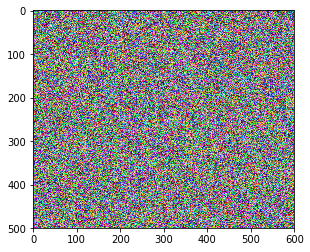

In [17]:
initial_image = get_noise_image(content_image, IMAGE_HEIGHT, IMAGE_WIDTH, NOISE_RATIO)
with tf.Session() as sess:
    plt.imshow(sess.run(initial_image[0]))

In [ ]:
train(model, input_image, initial_image)

Iter:  20 , loss:  3.65691e+09


In [17]:
content = Image.open(CONTENT_IMAGE)
style = Image.open(STYLE_IMAGE)
result = Image.open(FILENAME)

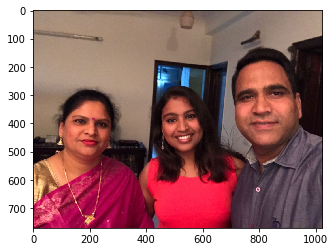

In [18]:
plt.imshow(np.asarray(content))

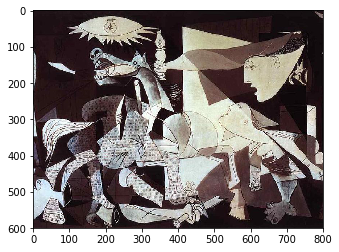

In [19]:
plt.imshow(np.asarray(style))

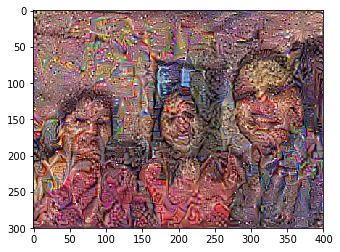

In [21]:
plt.imshow(np.asarray(result)) 